## Why do folks recommend flying steep spirals at 90 KIAS (in C172s and the Archer)?

The Airplane Flying Handbook (AFH) describe steep spirals as [...].

The Airmen Certification Standards (ACS) standards don't mention "best glide." The AFH only says to establish a "gliding speed"–not "best glide."

Seemingly every flight school's documentation shows 90 KIAS for both Cessna 172s and Piper Archers. This is around 15 knots higher than the best glide speed the POH publishes for max gross weight.

I bet you that, with the higher CL-max of the C172/Archer (around 1.51), the best glide speed during the constant-descent banked turn is closer to 90 than 100 KIAS.

349.7845035500366
339.56900710007324
329.35351065010985
319.1380142001465
308.9225177501831
298.7070213002197
288.4915248502563
278.27602840029294
268.06053195032956
257.8450355003662
247.62953905040277
237.41404260043936
227.19854615047595
216.98304970051254
206.76755325054913
196.55205680058572
186.3365603506223
176.1210639006589
165.9055674506955
155.69007100073208
145.47457455076866
135.25907810080525
125.04358165084186
114.82808520087846
104.61258875091507
94.39709230095167
84.18159585098827
73.96609940102488
63.750602951061474
53.53510650109807
43.31961005113467
33.104113601171264
22.88861715120786
12.673120701244459
2.4576242512810573
352.2421278013177
342.0266313513543
331.8111349013909
321.59563845142753
311.38014200146415
301.16464555150077
290.9491491015374
280.733652651574
270.5181562016106
260.30265975164724
250.08716330168383
239.87166685172042
229.656170401757
219.4406739517936
209.2251775018302
199.00968105186678
188.79418460190337
178.57868815193996
168.36319170197655


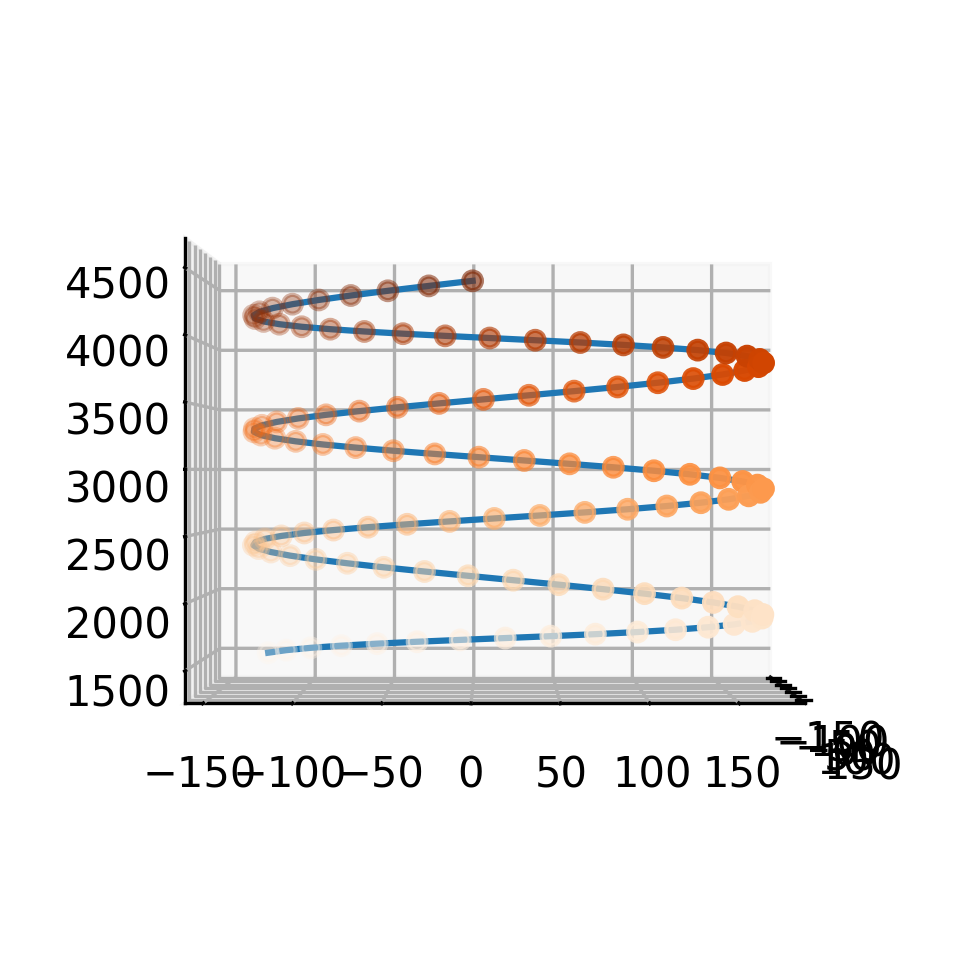

Rate of descent: -1618 FPM
Flight-path angle: -8.6°

Load factor: 1.398324 g
In a constant-altitude 45° banked turn, the load factor is 1.414214 g. By descending, we decrease the load factor by -0.01589 g (around -39.72 lbf).

Stall speed during constant-descent 45° banked turn: 75.1 KCAS
In a constant-altitude 45° banked turn, the stall speed is 75.52 KCAS. The descent decreases stall speed by 0.43 KCAS.

Best glide speed during constant-descent 45° banked turn: 95 KCAS
The best glide speed from the POH (scaled to 2,500 lbf gross weight) is 76 KCAS.


In [7]:
import numpy as np

from n51sw_dataplate import N51SW
from the_bootstrap_approach.equations import *
# Adjustable parameters of the simulation.
gross_aircraft_weight = 2500
density_altitude = 4500
calibrated_airspeed = 100
bank_angle = 50

relative_atmospheric_density = relative_atmospheric_density_alt(
    british_standard_temperature(density_altitude), density_altitude
)
atmospheric_density = atmospheric_density(relative_atmospheric_density)

# G multiplied by V^2 (V is TAS in ft/sec) yields parasite drag in pounds of force (lbf).
g = G(atmospheric_density, N51SW.reference_wing_area, N51SW.parasite_drag_coefficient)

# H divided by V^2 yields induced drag in lbf.
wings_level_h = H(
    gross_aircraft_weight,
    atmospheric_density,
    N51SW.reference_wing_area,
    N51SW.airplane_efficiency_factor,
    N51SW.wing_aspect_ratio,
)

# In wings-level, constant-altitude unaccelerated flight to our approximation
# (no off-axis thrust component), lift L is equal to weight W. When the pilot
# wants to turn the airplane, he or she banks to some angle Φ, tilting the lift
# vector towards the desired direction. To maintain altitude, the pilot also
# applies sufficient backstick, enlarging the vertical component of lift, to
# balance weight. Because increased lift means increased induced drag, the pilot
# must also add power if air speed is to be held constant.
# As mentioned, this additional induced drag while turning leads to the only
# modification of the wings-level bootstrap approach required to encompass
# quasi-steady-state maneuvering flight:
#
#                    H(0)
# H ≡ H(0) → H(Φ) ≡ ------                                               (8.22)
#                   cos² Φ
#
# The zero in parentheses denotes a value for unbanked, wings-level flight. For
# most (not all) intents and purposes, banking to angle Φ is tantamount to
# increasing gross weight from W to W / cos Φ.
banked_h = wings_level_h / np.cos(np.deg2rad(bank_angle)) ** 2

# VT is TAS in ft/sec.
ktas = tas(calibrated_airspeed, relative_atmospheric_density)
vt = kn_to_fts(ktas)

# Power available is zero in a power-off glide.
pre = power_required(g, banked_h, vt)
pav = 0
pxs = pav - pre

thrust = pav / vt
drag = pre / vt
excess_thrust = thrust - drag

rate_of_climb_or_descent = 60 * excess_thrust * vt / gross_aircraft_weight
flight_path_angle = np.rad2deg(np.arcsin(excess_thrust / gross_aircraft_weight))

import math
from dataclasses import dataclass
from typing import Union

# using dataclass to build the vector class
# unsafe_hash = True makes the class hashable
@dataclass(unsafe_hash=True)
class Vector:
    x: Union[int, float]
    y: Union[int, float]
    z: Union[int, float]

def tand(deg):
    return np.tan(np.deg2rad(deg))

def arctand(deg):
    return np.arctan(np.deg2rad(deg))


def cosd(deg):
    return np.cos(np.deg2rad(deg))

def sind(deg):
    return np.sin(np.deg2rad(deg))

def radius(air_speed, aircraft_bank_angle, flight_path_angle, acceleration_of_gravity=32.174):
    return (air_speed ** 2) / (acceleration_of_gravity * tand(aircraft_bank_angle) ** cosd(flight_path_angle))

def aircraft_turning_rate(air_speed, radius):
    return np.rad2deg(air_speed / radius)

# "Take an airplane (it does not matter what kind) travelling at 80 KTAS = 135.0
# ft/s, . . ., banked 30 deg. Equation (8.12) then gives radius of curvature R =
# 981.1 ft. And Eq. (8.13) implies the yaw rate is 0.1376 rad/s = 7.884 deg/s"
# (Lowry 242).
turn_radius = radius(135, 30, 0)
turn_rate = aircraft_turning_rate(135, turn_radius)

assert math.isclose(turn_radius, 981.1, abs_tol=10**-1)
assert math.isclose(turn_rate, 7.884, abs_tol=10**-3)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

descent_rate_fts = excess_thrust * vt / gross_aircraft_weight

heading = 360
bank_angle = 45

# Starting position, where each coordinate is represented in feet.
positions = [
    [0, 0, 4500]
]

# While we're above 1,500' AGL.
while positions[-1][2] >= 1500:
    turn_radius = radius(vt, bank_angle, flight_path_angle)
    turn_rate = aircraft_turning_rate(vt, turn_radius)

    # Subtracting the turn rate assuming the turn is made counterclockwise
    # (e.g., to the left).
    heading = (heading - turn_rate) % 360
    print(heading)

    current_pos = positions[-1]
    positions.append([
        current_pos[0] + (vt * sind(flight_path_angle) * cosd(heading)),
        current_pos[1] + (vt * sind(flight_path_angle) * cosd(heading)),
        current_pos[2] + descent_rate_fts
    ])

positions = np.array(positions)

x = positions[:, 0]
y = positions[:, 1]
z = positions[:, 2]

ax.plot3D(x, y, z)
ax.scatter3D(x, y, z, c=z, cmap='Oranges')


fig.set(dpi=300)
ax.view_init(0, 0)

plt.show()

print(f"Rate of descent: {int(rate_of_climb_or_descent)} FPM")
print(f"Flight-path angle: {np.around(flight_path_angle, 2)}°\n")

load_factor = np.cos(np.deg2rad(flight_path_angle)) / np.cos(np.deg2rad(bank_angle))
load_factor_level = np.cos(np.deg2rad(0)) / np.cos(np.deg2rad(bank_angle))
print(f"Load factor: {np.around(load_factor, 6)} g")

diff_load_factor = load_factor - load_factor_level
diff_weight = gross_aircraft_weight * diff_load_factor
print(
    f"In a constant-altitude {bank_angle}° banked turn, the load factor is {np.around(load_factor_level, 6)} g. By descending, we decrease the load factor by {np.around(diff_load_factor, 6)} g (around {np.around(diff_weight, 2):,} lbf).\n"
)


def lift_coefficient(
    gross_aircraft_weight, atmospheric_density, air_speed, reference_wing_area
):
    return (2 * gross_aircraft_weight) / (
        atmospheric_density * air_speed**2 * reference_wing_area
    )


# TODO: Write a test to validate Dr. Lowry's Cessna 172's CL-max example:
# cl_max = lift_coefficient(2400, 0.002377, kn_to_fts(52), 174)
# print(f"Cessna 172 CL-max: {np.around(cl_max, 2)}")

# First, we determine the calibrated airspeed at which the aircraft stalls at in
# the clean configuration, at MSL during standard day conditions. We can use
# this to determine CL-max, which should remain constant for the airfoil.
cl_max = lift_coefficient(
    gross_aircraft_weight,
    0.002377,  # MSL standard density in slug/ft^3.
    # According to the AFM, the Dakota stalls (VS1) at 66 KCAS at 3000 lbf gross
    # weight at MSL under standard day conditions.
    kn_to_fts(scale_v_speed_by_weight(66, 3000, gross_aircraft_weight)),
    N51SW.reference_wing_area,
)

# print(f"CL-max in the clean configuration: {np.around(cl_max, 2)}")

# With CL-max at hand, we can directly calculate stall speed under any condition.
wings_level_stall_speed = np.sqrt(
    (2 * gross_aircraft_weight * np.cos(np.deg2rad(flight_path_angle)))
    / (atmospheric_density * N51SW.reference_wing_area * cl_max)
)

banked_stall_speed = wings_level_stall_speed / np.sqrt(np.cos(np.deg2rad(bank_angle)))

constant_altitude_banked_stall_speed = np.sqrt(
    (2 * gross_aircraft_weight * 1)
    / (atmospheric_density * N51SW.reference_wing_area * cl_max)
) / np.sqrt(np.cos(np.deg2rad(bank_angle)))

diff_stall_speed = constant_altitude_banked_stall_speed - banked_stall_speed

print(
    f"Stall speed during constant-descent {bank_angle}° banked turn: {np.around(banked_stall_speed * 0.5924838, 2)} KCAS"
)
print(
    f"In a constant-altitude {bank_angle}° banked turn, the stall speed is {np.around(constant_altitude_banked_stall_speed * 0.5924838, 2)} KCAS. The descent decreases stall speed by {np.around(diff_stall_speed * 0.5924838, 2)} KCAS.\n"
)


def best_glide(g, h, relative_atmospheric_density):
    u = h / g

    return math.sqrt(relative_atmospheric_density) * 0.5924838 * u ** (1 / 4)


print(
    f"Best glide speed during constant-descent {bank_angle}° banked turn: {int(best_glide(g, banked_h, relative_atmospheric_density))} KCAS"
)
print(
    f"The best glide speed from the POH (scaled to {gross_aircraft_weight:,} lbf gross weight) is {int(best_glide(g, wings_level_h, relative_atmospheric_density))} KCAS."
)


## Further Reading (TODO: Explain all these links.)

- https://www.pprune.org/archive/index.php/t-603780.html
- https://aviation.stackexchange.com/questions/36062/what-is-the-formula-for-induced-drag
- https://aviation.stackexchange.com/questions/84982/how-to-calculate-best-glide-speed-at-a-30-degree-bank
- https://aviation.stackexchange.com/questions/74061/why-does-a-higher-load-factor-increase-stall-speed
- https://www.pprune.org/tech-log/10295-descending-turn-load-factor.html
- https://aviation.stackexchange.com/questions/51715/how-much-g-force-is-experienced-in-a-45-turn/51716#51716
- https://aviation.stackexchange.com/questions/82963/how-to-properly-compute-the-stable-vertical-path-load-factor
- https://www.airlinepilotforums.com/467236-post5.html
- https://www.airlinepilotforums.com/technical/31465-question-descnding-turn-load-factor-stall-speed-2.html